# Characterization of clades based on k-mers
Based on the results from the saliency maps and k-mer frequencies, I defined two subsets: 

- $P^{i}$: set of k-mers with positive frequency in clade $i$
- $A^{i}$: set of k-mers with 0 frequency in clade $i$

In order to give a characterization, I will find the relations between those sets among the clades.

1. $P^{i} \cap P^{j}$ gives the shared k-mers between two clades.
2. $A^{i} \cap A^{j}$ gives the shared *absents* k-mers between two clades, i.e., relevant k-mers that must not appear in neither of the the sequences.
3. $P^{i} \cap A^{j}$ gives the relevant k-mers that appears in clade $i$ and does not appear in clade $j$.
4. $P^{i} - P^{j}$ gives the relevant k-mers in clade $i$ that are independent of the clade $j$.

- 1 and 2 gave us a notion of similarity based on shared k-mers between two clades.
- 3 and 4 gave us a notion of disimilarity, i.e. how to differentiate two clades based on the appearance of k-mers.

**Note**
This characterization is based on the average computation of frequencies and saliency maps. Then, the average frequencies will be rounded to define the sets $P^i$ and $A^i$

- Average frequency: is a matrix with the average of all FCGR of one clade (only True Positives) 
- Average Saliency map: is a matrix with the average of all saliency maps of one clade (only True Positives) 
- Average kmer importance: is table with a a list of kmers, their frequency and the value of the associated gradient (>0.2)

- $P^i \cap A^i = \emptyset,  \forall i$

In [27]:
from collections import namedtuple, defaultdict 
from pathlib import Path
import numpy as np
import pandas as pd

In [29]:
CLADES = ['S','L','G','V','GR','GH','GV','GK']

# namedtuple to save P and A sets for each clade
SetsKmer = namedtuple("SetsKmer", ["P","A"])
AP_sets = defaultdict(SetsKmer)

In [36]:
clade = "S"

# path to avg results
path_avg = Path("avg-results-nextclade-comparison")

# load kmer importance
kmer_importance = pd.read_csv(path_avg.joinpath(f"{clade}/kmer_importance.csv"))

In [37]:
kmer_importance["freq"] = kmer_importance["freq"].apply(np.round)

In [38]:
A = set(kmer_importance.query("`freq`==0")["kmer"])
P = set(kmer_importance.query("`freq`>0")["kmer"])

In [39]:
AP_sets[clade] = SetsKmer(P,A)

In [40]:
AP_sets["S"]

SetsKmer(P={'TGTTCACC'}, A=set())

___

In [41]:
for clade in CLADES: 
    # load kmer importance
    kmer_importance = pd.read_csv(path_avg.joinpath(f"{clade}/kmer_importance.csv"))
    # round freq
    kmer_importance["freq"] = kmer_importance["freq"].apply(np.round)
    
    # compute P and A sets
    A = set(kmer_importance.query("`freq`==0")["kmer"])
    P = set(kmer_importance.query("`freq`>0")["kmer"])
    
    # save sets
    AP_sets[clade] = SetsKmer(P,A)

### 1. shared k-mers between 2 clades

In [75]:
shared_present_kmers = np.zeros((len(CLADES), len(CLADES)))

In [77]:
for i,clade1 in enumerate(CLADES[:-1]):
    for j,clade2 in enumerate(CLADES[i+1:]):
        P1 = AP_sets[clade1].P
        P2 = AP_sets[clade2].P
        shared_present_kmers[i,i+j+1]  = len(P1.intersection(P2))

In [78]:
pd.DataFrame(shared_present_kmers,index=CLADES, columns=CLADES)

,S,L,G,V,GR,GH,GV,GK
S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L,0.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0
G,0.0,0.0,0.0,1.0,0.0,6.0,0.0,1.0
V,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
GR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
GH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
GV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2. shared absent k-mers between 2 clades

In [79]:
shared_absent_kmers = np.zeros((len(CLADES), len(CLADES)))
for i,clade1 in enumerate(CLADES[:-1]):
    for j,clade2 in enumerate(CLADES[i+1:]):
        A1 = AP_sets[clade1].A
        A2 = AP_sets[clade2].A
        shared_absent_kmers[i,i+j+1]  = len(A1.intersection(A2))

In [80]:
pd.DataFrame(shared_absent_kmers,index=CLADES, columns=CLADES)

,S,L,G,V,GR,GH,GV,GK
S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L,0.0,0.0,3.0,2.0,1.0,2.0,0.0,0.0
G,0.0,0.0,0.0,2.0,0.0,8.0,0.0,0.0
V,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0
GR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. k-mers that appears in clade $i$ and does not appear in clade $j$

In [81]:
exp3_kmers = np.zeros((len(CLADES), len(CLADES)))
for i,clade1 in enumerate(CLADES[:-1]):
    for j,clade2 in enumerate(CLADES[i+1:]):
        P1 = AP_sets[clade1].P
        A2 = AP_sets[clade2].A
        exp3_kmers[i,i+j+1]  = len(P1.intersection(A2))  

In [82]:
pd.DataFrame(exp3_kmers,index=CLADES, columns=CLADES)

,S,L,G,V,GR,GH,GV,GK
S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
V,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GR,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
GH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 4. k-mers in clade $i$ that are independent of the clade $j$

In [83]:
exp4_kmers = np.zeros((len(CLADES), len(CLADES)))
for i,clade1 in enumerate(CLADES[:-1]):
    for j,clade2 in enumerate(CLADES[i+1:]):
        P1 = AP_sets[clade1].P
        A2 = AP_sets[clade2].P
        exp4_kmers[i,i+j+1]  = len(P1-P2)  

In [84]:
pd.DataFrame(exp4_kmers,index=CLADES, columns=CLADES)

,S,L,G,V,GR,GH,GV,GK
S,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
L,0.0,0.0,23.0,23.0,23.0,23.0,23.0,23.0
G,0.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0
V,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0
GR,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0
GH,0.0,0.0,0.0,0.0,0.0,0.0,18.0,18.0
GV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
GK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
AP_sets.get("GK")

# UpSet plots

In [143]:
from upsetplot import from_indicators, UpSet
import matplotlib.pyplot as plt

In [170]:
# get all present kmers
present_kmers = set()
for clade in CLADES: 
    kmers_clade = AP_sets.get(clade).P
    present_kmers = present_kmers.union(kmers_clade)

In [171]:
len(present_kmers)

48

In [172]:
# build
kmer_by_clade = {}

for kmer in present_kmers: 
    bool_kmer_clade = {}
    for clade in CLADES:
        P = AP_sets.get(clade).P
        if kmer in P: 
            bool_kmer_clade.update({clade: True})
        else:
            bool_kmer_clade.update({clade: False})
    
    kmer_by_clade[kmer] = bool_kmer_clade

In [173]:
df_kmer_by_clade = pd.DataFrame.from_dict(kmer_by_clade,orient="index")

In [174]:
# df_kmer_by_clade.sum(axis=1)

In [175]:
# df_kmer_by_clade.sum(axis=0)

In [176]:
kbc = from_indicators(df_kmer_by_clade,)

In [177]:
# kbc

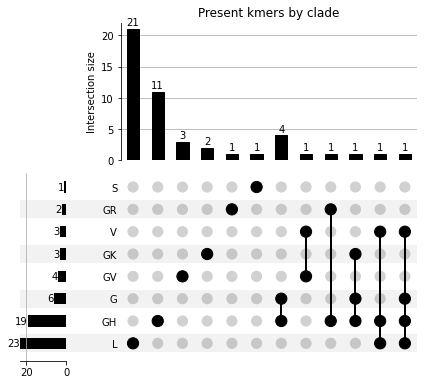

In [178]:
fig = UpSet(kbc,subset_size='count', show_counts=True)
fig.plot()
plt.title("Present kmers by clade")
plt.show()

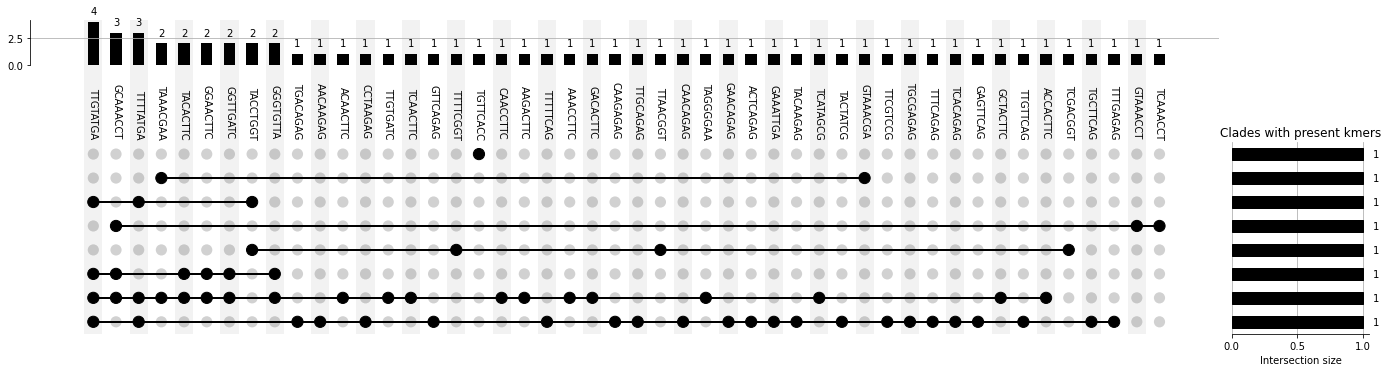

In [179]:
df_kmer_by_clade = pd.DataFrame.from_dict(kmer_by_clade,orient="columns")
kbc = from_indicators(df_kmer_by_clade,)
fig = UpSet(kbc,subset_size='count', show_counts=True, orientation="vertical")
fig.plot()
plt.title("Clades with present kmers")
plt.show()

In [118]:
df_kmer_by_clade["TGTTCACC"]

S      True
L     False
G     False
V     False
GR    False
GH    False
GV    False
GK    False
Name: TGTTCACC, dtype: bool

In [119]:
df_kmer_by_clade["TTGTATGA"]

S     False
L      True
G      True
V      True
GR    False
GH     True
GV    False
GK    False
Name: TTGTATGA, dtype: bool

In [121]:
CLADES

['S', 'L', 'G', 'V', 'GR', 'GH', 'GV', 'GK']

In [122]:
CLADES.sort()
CLADES

['G', 'GH', 'GK', 'GR', 'GV', 'L', 'S', 'V']

__
## absent kmers

In [155]:
# get all absent kmers
absent_kmers = set()
for clade in CLADES: 
    kmers_clade = AP_sets.get(clade).A
    absent_kmers = absent_kmers.union(kmers_clade)
len(absent_kmers)

79

In [164]:
# build
kmer_by_clade = {}

for kmer in absent_kmers: 
    bool_kmer_clade = {}
    for clade in CLADES:
        P = AP_sets.get(clade).A
        if kmer in P: 
            bool_kmer_clade.update({clade: True})
        else:
            bool_kmer_clade.update({clade: False})
    
    kmer_by_clade[kmer] = bool_kmer_clade

In [165]:
df_kmer_by_clade = pd.DataFrame.from_dict(kmer_by_clade,orient="index")

In [166]:
kbc = from_indicators(df_kmer_by_clade,)

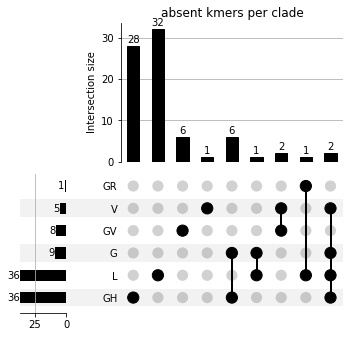

In [167]:
fig = UpSet(kbc,subset_size='count', show_counts=True)
fig.plot()
plt.title("absent kmers per clade")
plt.show()

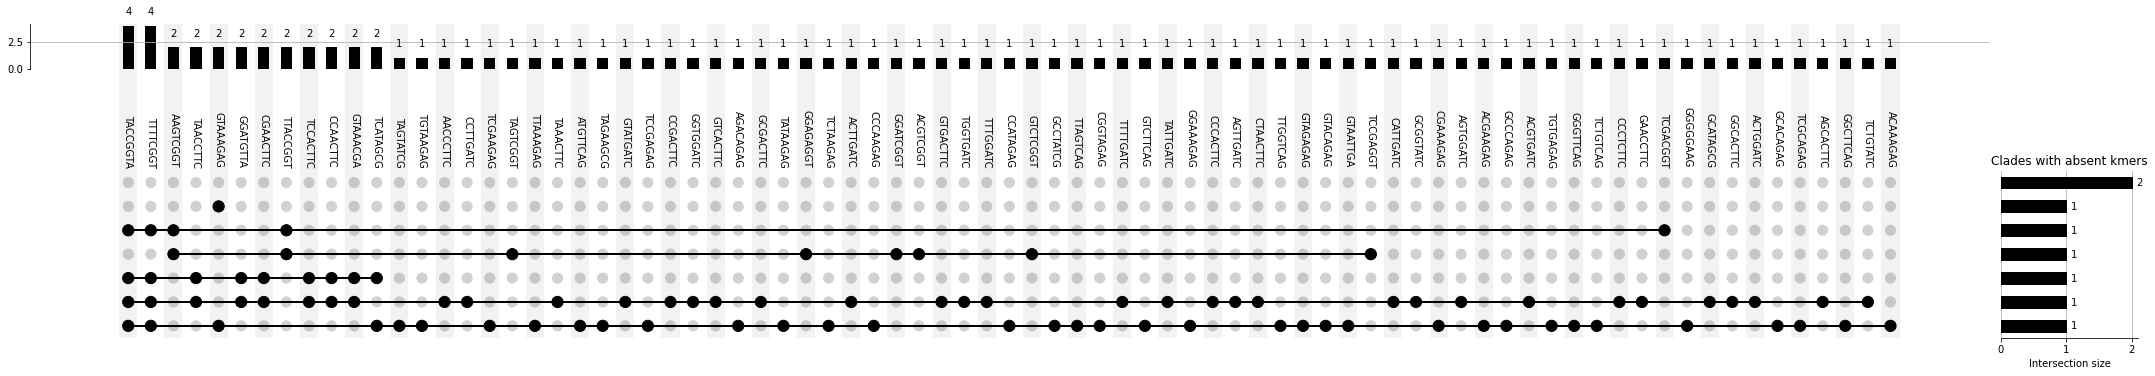

In [168]:
df_kmer_by_clade = pd.DataFrame.from_dict(kmer_by_clade,orient="columns")
kbc = from_indicators(df_kmer_by_clade,)
fig = UpSet(kbc,subset_size='count', show_counts=True, orientation="vertical")
fig.plot()
plt.title("Clades with absent kmers")
plt.show()

In [169]:
df_kmer_by_clade.sum(axis=1)

G      9
GH    36
GK     0
GR     1
GV     8
L     36
S      0
V      5
dtype: int64